In [22]:
!pip install pyngrok streamlit fpdf

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.6 MB/s eta 0:00:00
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=8cb923e6dd441812e4e9b04406ea64fc778d9ba73d29ee52662087f2465bd245
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


In [61]:
code = '''
import streamlit as st
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import ast
from fpdf import FPDF
from google.colab import files
import io
from PIL import Image

encoders = pd.read_csv("/content/drive/MyDrive/breast_tumor_prediction/encoders.csv")
encoders_dict = {}
for column in encoders.columns:
    encoders_dict[column] = dict(encoders[column].dropna().to_dict())

image_view = []
left_or_right_breast=[]
calc_type=[]
calc_distribution=[]
for feature, data in encoders_dict.items():
    if 1 in data:
        feature_dict_str = data[1].replace('nan', 'None')
        feature_dict = eval(feature_dict_str)
        feature_list = list(feature_dict.keys())
        globals()[feature] = feature_list

special_labels = ['assessment', 'breast_density']

mammo_model = load_model("/content/drive/MyDrive/breast_tumor_prediction/binary_classification_model.h5")
pathology_model=load_model("/content/drive/MyDrive/breast_cancer_detection/pathology_model.h5")
multi_label_model = load_model("/content/drive/MyDrive/breast_tumor_prediction/multi_label_classification_model.h5")


def preprocess_image_patho(uploaded_image):
    img = cv2.imdecode(np.frombuffer(uploaded_image.read(), np.uint8),  cv2.IMREAD_COLOR)
    img = cv2.resize(img,(50, 50))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img


def preprocess_image_mammo(uploaded_image):
    img = cv2.imdecode(np.frombuffer(uploaded_image.read(), np.uint8), -1)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert to 3 channels (RGB)
    img = cv2.resize(img, (224, 224))  # Resize to the correct shape
    img = img / 255.0  # Normalize to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension (1, 224, 224, 3)
    return img

def predict_mammo(image):
    binary_prediction = mammo_model.predict(image)
    if binary_prediction > 0.1:
        return 1
    else:
        return 0

def predict_pathology(image):
    prob = pathology_model.predict(image)
    prediction =0 if prob<=0.5 else 1
    return prediction

def mri_visualize (uploaded_image):
  image = cv2.imdecode(np.frombuffer(uploaded_image.read(), np.uint8),  cv2.IMREAD_COLOR)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  normalized = cv2.normalize(gray, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

  tumor_threshold = 0.5
  normal_threshold = 0.2

  heatmap = np.zeros((gray.shape[0], gray.shape[1], 3), dtype=np.uint8)

  heatmap[(normalized <= normal_threshold)] = [255,0,255 ]
  heatmap[(normalized > normal_threshold) & (normalized < tumor_threshold)] = [0, 255, 255]
  heatmap[(normalized >= tumor_threshold)] = [255, 0, 0]
  tint = cv2.addWeighted(image,0.5,np.full_like(image, (0, 255, 0)),0.5,0)

  overlay = cv2.addWeighted(tint, 0.7, heatmap, 0.3, 0)

  return image,heatmap,overlay

def generate_report(image):
    multi_label_prediction = multi_label_model.predict(image)

    report = f"""
                                                            Full Report

Findings:
The mammographic examination reveals that the image was taken using the {image_view[np.argmax(multi_label_prediction[0])]} view.
The evaluation of the breast indicates that the {left_or_right_breast[np.argmax(multi_label_prediction[1])]} side was examined.
{("No calcifications were observed, and therefore, no distribution pattern is noted." if calc_type[np.argmax(multi_label_prediction[2])] == None
else f"Regarding calcifications, the type identified is {calc_type[np.argmax(multi_label_prediction[2])]}. The calcification distribution is classified as {calc_distribution[np.argmax(multi_label_prediction[3])]}.")}
The breast density assessment resulted in a classification of {np.argmax(multi_label_prediction[4])}, which may have implications for screening sensitivity.
Cancer Assessment:
The analysis suggests a cancer assessment score of {np.argmax(multi_label_prediction[5])}. Further evaluation and correlation with clinical findings, as well as additional imaging if necessary, are recommended.

Conclusion:
These findings should be interpreted in conjunction with the patient's clinical history and prior imaging studies. Consultation with a radiologist or oncologist is advised for further assessment if needed.

  """
    return report

def generate_pdf(report_text, images):
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()
    pdf.set_font("Arial", size=12)

    pdf.multi_cell(0, 10, report_text)
    for img_title, img in images.items():
        pdf.add_page()
        pdf.set_font("Arial", style='B', size=14)
        pdf.cell(200, 10, img_title, ln=True, align='C')

        img_path = f"temp_{img_title}.jpg"
        img.save(img_path)
        pdf.image(img_path, x=10, y=30, w=180)

    pdf_output = pdf.output(dest='S').encode('latin1')

    return io.BytesIO(pdf_output)

def predict_other_features(image):
    # Predict using the multi-label model
    multi_label_prediction = multi_label_model.predict(image)

    predictions = []
    for idx, prediction in enumerate(multi_label_prediction):
        if idx == 5:
            predictions.append("Cancer Assessment: " + str(np.argmax(prediction)))
        elif idx == 4:
            predictions.append("Breast Density Number: " + str(np.argmax(prediction)))
        else:
            max_index = np.argmax(prediction)
            if idx == 0:
                predictions.append(f"Mammography Image View: {image_view[max_index]}")
            elif idx == 1:

                predictions.append(f"Side of The Breast: {left_or_right_breast[max_index]}")
            elif idx == 2:
                predictions.append(f"Calcification Type: {calc_type[max_index]}")
            elif idx == 3:
                if predictions[2].split(':')[1]== ' None':
                   predictions.append(f"Calcification Distribution: None")
                else:
                   predictions.append(f"Calcification Distribution: {calc_distribution[max_index]}")

    return predictions


st.title("Breast Cancer Detection")
st.write("Upload a breast tumor image for prediction")

uploaded_mammo = st.file_uploader("Choose Mammography Image...", type=["jpg", "png"])

if uploaded_mammo is not None:
  mammo_image = preprocess_image_mammo(uploaded_mammo)

  st.subheader("Please Wait For The Results Of The Mammography:")
  Mammo_result = predict_mammo(mammo_image)
  if Mammo_result==0:
    st.write("Benign")

  if Mammo_result == 1:
    st.subheader("There is Suspicion of Malignant Neoplasm...")
    st.image(uploaded_mammo, caption="Uploaded Mammography", use_container_width=True)
    st.subheader("Please Upload Your Pathology Tests...")
    uploaded_patho = st.file_uploader("Choose Pathology Image...", type=["jpg", "png"])
    if uploaded_patho is not None:
      patho_image = preprocess_image_patho(uploaded_patho)
      st.subheader("Please Wait For The Results Of The Pathology:")

      Patho_result = predict_pathology(patho_image)

      if Patho_result==0:
        st.write("Benign")
      if Patho_result==1:
        st.subheader("There Is Cancer...")
        st.image(uploaded_patho, caption="Uploaded Pathology", use_container_width=True)

        st.subheader("Please Upload Your MRI Tests To Visualize it...")
        uploaded_mri = st.file_uploader("Choose MRI Image...", type=["jpg", "png"])
        if uploaded_mri is not None:
          image,heatmap,overlay = mri_visualize(uploaded_mri)
          st.subheader("Here's The Visualization Of The Cancer in The MRI:")
          col1, col2, col3 = st.columns(3)
          with col1:
            st.image(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), caption="Original MRI", use_container_width=True)
          with col2:
            st.image(heatmap, caption="Heatmap", use_container_width=True)
          with col3:
            st.image(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB), caption="Overlay", use_container_width=True)

          st.subheader("Please Wait while Generating The Full Report:")
          report_text = generate_report(mammo_image)

          st.subheader("Download the Full Report:")
          images = {
                        "Mammography Image": Image.open(uploaded_mammo),
                        "Pathology Image": Image.open(uploaded_patho),
                        "Original MRI": Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)),
                        "Heatmap": Image.fromarray(heatmap),
                        "Overlay": Image.fromarray(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)),
                    }
          pdf_file = generate_pdf(report_text, images)
          st.download_button(label="Download Full Report", data=pdf_file, file_name="Breast_Cancer_Report.pdf", mime="application/pdf")



    st.markdown("""
        <style>
            .css-1v0mbdj {background-color: #f7f7f7; padding: 10px; border-radius: 10px;}
            h1 {color: #6a1b9a;}
            h2 {color: #d32f2f;}
            .stButton button {background-color: #6a1b9a; color: white; border-radius: 5px;}
        </style>
    """, unsafe_allow_html=True)
'''

with open("app.py", "w") as file:
    file.write(code)


In [62]:
from pyngrok import ngrok
import os
ngrok.set_auth_token("2po83xsmq48ye6YRys2U9EeM6Ke_87y32DWJ2exfm264W7u37")


public_url = ngrok.connect(8501, "http")
print(f"Streamlit app is live at: {public_url}")
!streamlit run app.py &


Streamlit app is live at: NgrokTunnel: "https://93a9-34-82-18-156.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.82.18.156:8501

2025-03-08 05:44:49.652 Uncaught exception GET /_stcore/stream (127.0.0.1)
HTTPServerRequest(protocol='http', host='93a9-34-82-18-156.ngrok-free.app', method='GET', uri='/_stcore/stream', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/streamlit/web/bootstrap.py", line 345, in run
    if asyncio.get_running_loop().is_running():
       ^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: no running event loop

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tornado/websocket.py", line 938, in _accept_connection
    open_result = handler.open

In [23]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import ast
from fpdf import FPDF
from google.colab import files
import io
from PIL import Image

In [ ]:

encoders = pd.read_csv("/content/drive/MyDrive/breast_tumor_prediction/encoders.csv")
encoders_dict = {}
for column in encoders.columns:
    encoders_dict[column] = dict(encoders[column].dropna().to_dict())

image_view = []
left_or_right_breast=[]
calc_type=[]
calc_distribution=[]
for feature, data in encoders_dict.items():
    if 1 in data:
        feature_dict_str = data[1].replace('nan', 'None')
        feature_dict = eval(feature_dict_str)
        feature_list = list(feature_dict.keys())
        globals()[feature] = feature_list

special_labels = ['assessment', 'breast_density']

mammo_model = load_model("/content/drive/MyDrive/breast_tumor_prediction/binary_classification_model.h5")
pathology_model=load_model("/content/drive/MyDrive/breast_cancer_detection/pathology_model.h5")
multi_label_model = load_model("/content/drive/MyDrive/breast_tumor_prediction/multi_label_classification_model.h5")

In [59]:
def preprocess_image_patho(uploaded_image):
    img = cv2.imdecode(np.frombuffer(uploaded_image.read(), np.uint8),  cv2.IMREAD_COLOR)
    img = cv2.resize(img,(50, 50))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img


def preprocess_image_mammo(uploaded_image):
    img = cv2.imdecode(np.frombuffer(uploaded_image.read(), np.uint8), -1)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def predict_mammo(image):
    binary_prediction = mammo_model.predict(image)
    if binary_prediction > 0.3:
        return 1
    else:
        return 0

def predict_pathology(image):
    prob = pathology_model.predict(image)
    prediction =0 if prob<=0.5 else 1
    return prediction

def mri_visualize (uploaded_image):
  image = cv2.imdecode(np.frombuffer(uploaded_image.read(), np.uint8),  cv2.IMREAD_COLOR)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  normalized = cv2.normalize(gray, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

  tumor_threshold = 0.6
  normal_threshold = 0.3

  heatmap = np.zeros((gray.shape[0], gray.shape[1], 3), dtype=np.uint8)

  heatmap[(normalized <= normal_threshold)] = [255,0,255 ]
  heatmap[(normalized > normal_threshold) & (normalized < tumor_threshold)] = [0, 255, 255]
  heatmap[(normalized >= tumor_threshold)] = [255, 0, 0]
  tint = cv2.addWeighted(image,0.5,np.full_like(image, (0, 255, 0)),0.5,0)

  overlay = cv2.addWeighted(tint, 0.7, heatmap, 0.3, 0)

  return image,heatmap,overlay
def predict_other_features(image):
    # Predict using the multi-label model
    multi_label_prediction = multi_label_model.predict(image)

    predictions = []
    for idx, prediction in enumerate(multi_label_prediction):
        if idx == 5:
            predictions.append("Cancer Assessment: " + str(np.argmax(prediction)))
        elif idx == 4:
            predictions.append("Breast Density Number: " + str(np.argmax(prediction)))
        else:
            max_index = np.argmax(prediction)
            if idx == 0:
                predictions.append(f"Mammography Image View: {image_view[max_index]}")
            elif idx == 1:

                predictions.append(f"Side of The Breast: {left_or_right_breast[max_index]}")
            elif idx == 2:
                predictions.append(f"Calcification Type: {calc_type[max_index]}")
            elif idx == 3:
                if predictions[2].split(':')[1]== ' None':
                   predictions.append(f"Calcification Distribution: None")
                else:
                   predictions.append(f"Calcification Distribution: {calc_distribution[max_index]}")

    return predictions

def generate_report(image):
    multi_label_prediction = multi_label_model.predict(image)

    report = f"""
        Full Report


        Findings:
        The mammographic examination reveals that the image was taken using the {image_view[np.argmax(multi_label_prediction[0])]} view.
        The evaluation of the breast indicates that the {left_or_right_breast[np.argmax(multi_label_prediction[1])]} side was examined.


        {("No calcifications were observed, and therefore, no distribution pattern is noted." if calc_type[np.argmax(multi_label_prediction[2])] == None
         else f"Regarding calcifications, the type identified is {calc_type[np.argmax(multi_label_prediction[2])]}. The calcification distribution is classified as {calc_distribution[np.argmax(multi_label_prediction[3])]}.")}

        The breast density assessment resulted in a classification of {np.argmax(multi_label_prediction[4])}, which may have implications for screening sensitivity.

        Cancer Assessment:
        The analysis suggests a cancer assessment score of {np.argmax(multi_label_prediction[5])}. Further evaluation and correlation with clinical findings, as well as additional imaging if necessary, are recommended.

        Conclusion:
        These findings should be interpreted in conjunction with the patient's clinical history and prior imaging studies. Consultation with a radiologist or oncologist is advised for further assessment if needed.

  """
    return report


def generate_pdf(report_text, images):
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()
    pdf.set_font("Arial", size=12)

    # Add report text
    pdf.multi_cell(0, 10, report_text)

    # Add images
    for img_title, img in images.items():
        pdf.add_page()
        pdf.set_font("Arial", style='B', size=14)
        pdf.cell(200, 10, img_title, ln=True, align='C')

        img_path = f"temp_{img_title}.jpg"
        img.save(img_path)
        pdf.image(img_path, x=10, y=30, w=180)

    pdf_output = io.BytesIO()
    pdf.output(pdf_output, 'F')
    pdf_output.seek(0)
    return pdf_output

def generate_pdf2(report_text, images):
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()
    pdf.set_font("Arial", size=12)

    pdf.multi_cell(0, 10, report_text)

    for img_title, img in images.items():
        pdf.add_page()
        pdf.set_font("Arial", style='B', size=14)
        pdf.cell(200, 10, img_title, ln=True, align='C')

        img_path = f"temp_{img_title}.jpg"
        img.save(img_path)
        pdf.image(img_path, x=10, y=30, w=180)

    pdf_output = io.BytesIO()
    pdf_bytes = pdf.output(dest='S').encode('latin1')
    pdf_output.write(pdf_bytes)
    pdf_output.seek(0)

    return pdf_output


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
there is suspcious of malignant
upload pathology test
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
there is a cancer 
upload MRI


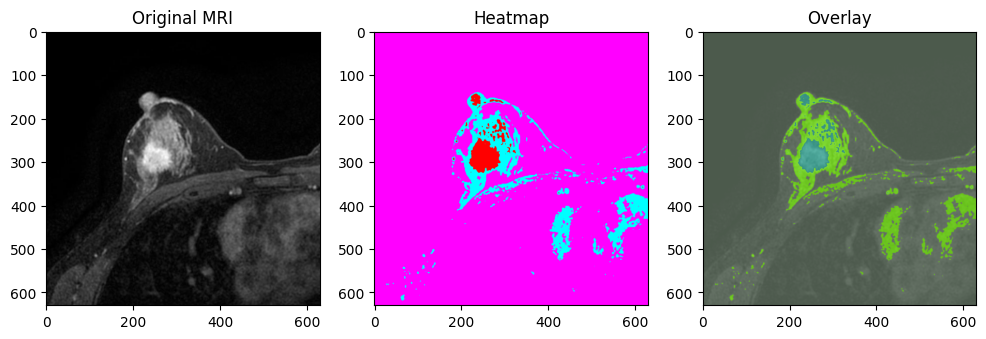

wait for Report
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
image_path = 'M.jpg'

# Open and preprocess the image
with open(image_path, "rb") as f:
    mammo_bytes = f.read()

    uploaded_mammo = io.BytesIO(mammo_bytes)
    processed_image_mammo = preprocess_image_mammo(uploaded_mammo)

# Run predictions
mammo_prediction = predict_mammo(processed_image_mammo)
if mammo_prediction==0:
  print("Benign")
else:
  print("there is suspcious of malignant")
  print("upload pathology test")
  image_path = 'PM1.png'
  with open(image_path, "rb") as f:
      patho_bytes = f.read()

  uploaded_patho = io.BytesIO(patho_bytes)
  processed_image_patho = preprocess_image_patho(uploaded_patho)
  patho_prediction = predict_pathology(processed_image_patho)
  if patho_prediction==0:
    print("Benign")
  else:
    print("there is a cancer ")
    print("upload MRI")
    image_path = 'breast_mri.jpg'

# Open and preprocess the image
    with open(image_path, "rb") as f:
        image,heatmap,overlay = mri_visualize(f)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title("Original MRI")
    plt.subplot(1, 3, 2), plt.imshow(heatmap), plt.title("Heatmap")
    plt.subplot(1, 3, 3), plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)), plt.title("Overlay")
    plt.show()
    print("wait for Report")

    multi_label_predictions = generate_report(processed_image_mammo)
    images = {
                        "Mammography Image": Image.open(uploaded_mammo),
                        "Pathology Image": Image.open(uploaded_patho),
                        "Original MRI": Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)),
                        "Heatmap": Image.fromarray(heatmap),
                        "Overlay": Image.fromarray(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)),
                    }

    pdf_output = generate_pdf2(multi_label_predictions, images)
    import tempfile

    # Save PDF to a temporary file
    temp_pdf_path = tempfile.NamedTemporaryFile(delete=False, suffix=".pdf").name

    with open(temp_pdf_path, "wb") as f:
        f.write(pdf_output.getvalue())  # Write BytesIO content to file

    # Download the file using Colab's file download
    files.download(temp_pdf_path)